### Load the Dream Dataset

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from scipy.stats import randint

# 1. SETUP PATHS
INPUT_FILENAME = "features_sell_12h.parquet"  # <--- CHANGED TO SELL
INPUT_PATH = os.path.join('../data', INPUT_FILENAME)
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)

# 2. LOAD DATA
if os.path.exists(INPUT_PATH):
    print(f"📉 Loading SELL Dataset from {INPUT_PATH}...")
    df = pd.read_parquet(INPUT_PATH)
    print(f"Dataset Shape: {df.shape}")
else:
    raise FileNotFoundError(f"CRITICAL: File not found at {INPUT_PATH}. Run Notebook 3 first.")

📉 Loading SELL Dataset from ../data\features_sell_12h.parquet...
Dataset Shape: (9313, 11)


### Prepare Training Data (X & y)

In [2]:
# 1. SEPARATE FEATURES AND TARGET
target_col = 'target'
X = df.drop(columns=[target_col])
y = df[target_col]

# 2. CREATE THE "VAULT" (Holdout Set)
split_point = int(len(X) * 0.80)

X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]

X_test_vault = X.iloc[split_point:]
y_test_vault = y.iloc[split_point:]

print(f"--- SPLIT COMPLETE ---")
print(f"Training Set : {len(X_train)} rows")
print(f"Vault Set    : {len(X_test_vault)} rows")
print(f"\nTraining Class Balance (Target=1 represents SELL):\n{y_train.value_counts(normalize=True)}")

--- SPLIT COMPLETE ---
Training Set : 7450 rows
Vault Set    : 1863 rows

Training Class Balance (Target=1 represents SELL):
target
0    0.682819
1    0.317181
Name: proportion, dtype: float64


### Configure the Optimization (The "Thorough" Search)

In [3]:
# 1. VALIDATION STRATEGY (Internal CV on Training Data)
# 5 Splits with a 50-step gap to prevent overlap
tscv = TimeSeriesSplit(n_splits=5, gap=50)

# 2. SEARCH SPACE (Aggressive / High-Signal Config)
param_dist = {
    # Trees: 250-1000 for stability
    'n_estimators': randint(250, 1000),
    
    # Depth: 8-20 (Allowing deeper trees to find specific setups)
    'max_depth': randint(10, 25),
    
    # Leaf Size: 15-100 (Slightly lower min to catch more signals)
    'min_samples_leaf': randint(20, 100),
    
    # Randomness
    'max_features': ['sqrt', 'log2'],

    'bootstrap': [True],
    
    # Class Weight: Critical test. 
    # 'None' = let majority rule. 'balanced' = help the minority Hold.
    'class_weight': ['balanced', 'balanced_subsample'],
    
    # Split Quality
    'criterion': ['gini', 'entropy']
}

print("Configuration Ready: Optimization will run on Training Set only.")

Configuration Ready: Optimization will run on Training Set only.


### Execute Random Search

In [4]:
# 1. INITIALIZE MODEL
rf = RandomForestClassifier(random_state=42)

# 2. INITIALIZE SEARCH
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='precision', # Maximize accuracy of Sell Signals
    cv=tscv,
    verbose=1,
    random_state=42,
    # n_jobs=-1
)

# 3. RUN TRAINING
print(f"🚀 Starting optimization for SELL Model...")
search.fit(X_train, y_train)

print("\n--- OPTIMIZATION COMPLETE ---")
print(f"Best Precision Score (CV): {search.best_score_:.4f}")
print("Best Parameters:", search.best_params_)

🚀 Starting optimization for SELL Model...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- OPTIMIZATION COMPLETE ---
Best Precision Score (CV): 0.3997
Best Parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 56, 'n_estimators': 348}


### Final Evaluation & Feature Importance

### The "Honest Test" (Evaluation)

In [5]:
# 1. GET THE WINNER
best_model = search.best_estimator_

# 2. PREDICT ON VAULT DATA
print("Running prediction on Vault (Holdout) data...")
y_pred_vault = best_model.predict(X_test_vault)

# 3. REPORT
# Target 1 here means "SELL", Target 0 means "Noise"
print("\n--- 🔒 HONEST TEST RESULTS (SELL MODEL) ---")
print(classification_report(y_test_vault, y_pred_vault, target_names=['Noise (0)', 'Sell Signal (1)']))




Running prediction on Vault (Holdout) data...

--- 🔒 HONEST TEST RESULTS (SELL MODEL) ---
                 precision    recall  f1-score   support

      Noise (0)       0.75      0.53      0.62      1281
Sell Signal (1)       0.37      0.62      0.47       582

       accuracy                           0.56      1863
      macro avg       0.56      0.57      0.54      1863
   weighted avg       0.63      0.56      0.57      1863

✅ Saved Sell Model to: ../models\EURUSD_Sell_Model_12h_20260103_1820.joblib


### #  SAVE BUNDLE

In [ ]:

timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M")
filename = f'EURUSD_Sell_Model_12h_{timestamp}.joblib'
full_path = os.path.join(MODEL_DIR, filename)

bundle = {
    'model': best_model,
    'type': 'SELL_SIDE',
    'horizon': '12 Hours',
    'feature_names': list(X_train.columns),
    'best_params': search.best_params_,
    'best_cv_score': search.best_score_
}

joblib.dump(bundle, full_path)
print(f"✅ Saved Sell Model to: {full_path}")

### -----------------TESTING STARTS HERE !!-----------------------

### Configuration

In [15]:
import os

# 1. SELECT YOUR MODEL FILE
# Copy the path from the output of the previous notebook
MODEL_FILEPATH = "../models/EURUSD_Sell_Model_12h_20260103_1820.joblib" 

# 2. SELECT THE CORRESPONDING DATA FILE
DATA_FILEPATH = "../data/features_sell_12h.parquet"

# Check if they exist
if not os.path.exists(MODEL_FILEPATH) or not os.path.exists(DATA_FILEPATH):
    print("❌ Critical Error: One or both file paths are incorrect.")
else:
    print(f"✅ Ready to analyze:\n  Model: {os.path.basename(MODEL_FILEPATH)}\n  Data:  {os.path.basename(DATA_FILEPATH)}")

✅ Ready to analyze:
  Model: EURUSD_Sell_Model_12h_20260103_1820.joblib
  Data:  features_sell_12h.parquet


### Load & Reconstruct Vault

In [16]:
import joblib
import pandas as pd
import numpy as np

def load_and_prep(model_path, data_path):
    print(f"--- 🔓 Opening Vault ---")
    
    # 1. Load Bundle
    bundle = joblib.load(model_path)
    model = bundle['model']
    expected_features = bundle['feature_names']
    
    print(f" > Model Type: {bundle.get('type', 'Unknown')}")
    print(f" > Horizon:    {bundle.get('horizon', 'Unknown')}")
    print(f" > CV Score:   {bundle.get('best_cv_score', 0):.4f}")
    
    # 2. Load Data
    df = pd.read_parquet(data_path)
    
    # 3. Reconstruct the Split (Train vs Vault)
    # We must do this to isolate the exact same test data used before
    target_col = 'target'
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    split_point = int(len(X) * 0.80)
    X_test_vault = X.iloc[split_point:]
    y_test_vault = y.iloc[split_point:]
    
    # 4. Feature Alignment (Safety Check)
    # Ensure columns are in the exact order the model expects
    X_aligned = X_test_vault[expected_features]
    
    print(f"✅ Data Loaded. Vault Size: {len(X_aligned)} rows.")
    return model, X_aligned, y_test_vault, bundle.get('type', 'Signal')

# Execute
model, X_test, y_test, model_type = load_and_prep(MODEL_FILEPATH, DATA_FILEPATH)

--- 🔓 Opening Vault ---
 > Model Type: SELL_SIDE
 > Horizon:    12 Hours
 > CV Score:   0.3997
✅ Data Loaded. Vault Size: 1863 rows.


### Diagnostic Functions (Binary Edition)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def run_diagnostics(model, X_test, y_test, model_type):
    
    # --- A. PREDICTIONS ---
    probs = model.predict_proba(X_test)
    preds = model.predict(X_test)
    
    # probs[:, 1] is the probability of Class 1 (Signal)
    signal_probs = probs[:, 1]

    # --- B. CONFUSION MATRIX ---
    print(f"\n--- 1. Confusion Matrix ({model_type}) ---")
    cm = confusion_matrix(y_test, preds)
    
    # Labels for the plot
    labels = ['Noise (0)', f'{model_type} (1)']
    
    # Calculate Precision (Trustworthiness)
    # TP / (TP + FP)
    precision = precision_score(y_test, preds, zero_division=0)
    recall = recall_score(y_test, preds, zero_division=0)
    
    print(f"🎯 Precision (Win Rate): {precision:.2%}")
    print(f"📡 Recall (Capture Rate):  {recall:.2%}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model_type}')
    plt.show()

    # --- C. CONFIDENCE DISTRIBUTION ---
    print("\n--- 2. How confident is the model? ---")
    
    conf_df = pd.DataFrame({
        'True_Label': y_test.values,
        'Signal_Prob': signal_probs
    })
    
    plt.figure(figsize=(10, 4))
    
    # Plot Noise Distribution
    sns.kdeplot(data=conf_df[conf_df['True_Label']==0], x='Signal_Prob', fill=True, color='gray', label='Noise (0)', alpha=0.3)
    # Plot Signal Distribution
    sns.kdeplot(data=conf_df[conf_df['True_Label']==1], x='Signal_Prob', fill=True, color='green', label='Signal (1)', alpha=0.3)
    
    plt.axvline(0.5, color='red', linestyle='--', label='Default Threshold (0.5)')
    plt.title(f"Probability Distribution: Noise vs {model_type}")
    plt.xlabel(f"Probability of {model_type}")
    plt.legend()
    plt.show()

    # --- D. FEATURE IMPORTANCE ---
    print("\n--- 3. Top Drivers ---")
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feats = X_test.columns
        indices = np.argsort(importances)[::-1][:10] # Top 10
        
        plt.figure(figsize=(8, 5))
        sns.barplot(x=importances[indices], y=feats[indices], palette='viridis')
        plt.title(f'Top 10 Features for {model_type}')
        plt.show()

### Threshold Sensitivity Analysis

In [18]:
def analyze_thresholds(model, X_test, y_test, model_type):
    print(f"--- 🎚️ Sensitivity Analysis: {model_type} ---")
    
    # Get probabilities for Class 1 (Signal)
    probs = model.predict_proba(X_test)[:, 1]
    true_labels = y_test.values
    
    # Test thresholds from 0.50 up to 0.80
    thresholds = np.arange(0.50, 0.82, 0.02)
    results = []
    
    for thresh in thresholds:
        # Create hard predictions based on new threshold
        # If prob > thresh, predict 1, else 0
        custom_preds = (probs >= thresh).astype(int)
        
        # Calculate Stats
        # How many trades did we take?
        n_trades = custom_preds.sum()
        
        if n_trades == 0:
            prec = 0.0
        else:
            # Precision = True Positives / Predicted Positives
            # We filter for where we predicted 1, and check if label was actually 1
            tp = ((custom_preds == 1) & (true_labels == 1)).sum()
            prec = tp / n_trades
            
        results.append({
            'Threshold': thresh,
            'Precision': prec,
            'Trade_Count': n_trades
        })
        
    df_res = pd.DataFrame(results)
    
    # Print Table
    print("\n📊 Threshold Impact Table:")
    print(df_res.to_string(index=False, float_format="%.3f"))
    
    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # Precision Line
    ax1.plot(df_res['Threshold'], df_res['Precision'], 'g-o', label='Precision (Win Rate)')
    ax1.set_xlabel('Confidence Threshold')
    ax1.set_ylabel('Precision', color='green')
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.grid(True, alpha=0.3)
    
    # Volume Bar
    ax2 = ax1.twinx()
    ax2.bar(df_res['Threshold'], df_res['Trade_Count'], alpha=0.2, color='gray', width=0.015, label='Trade Volume')
    ax2.set_ylabel('Number of Trades', color='gray')
    
    plt.title(f"Precision vs. Volume for {model_type}")
    plt.show()




--- 🎚️ Sensitivity Analysis: SELL_SIDE ---

📊 Threshold Impact Table:
 Threshold  Precision  Trade_Count
     0.500      0.374          966
     0.520      0.376          842
     0.540      0.379          728
     0.560      0.394          602
     0.580      0.376          449
     0.600      0.372          301
     0.620      0.341          167
     0.640      0.413           75
     0.660      0.316           19
     0.680      0.000            1
     0.700      0.000            0
     0.720      0.000            0
     0.740      0.000            0
     0.760      0.000            0
     0.780      0.000            0
     0.800      0.000            0


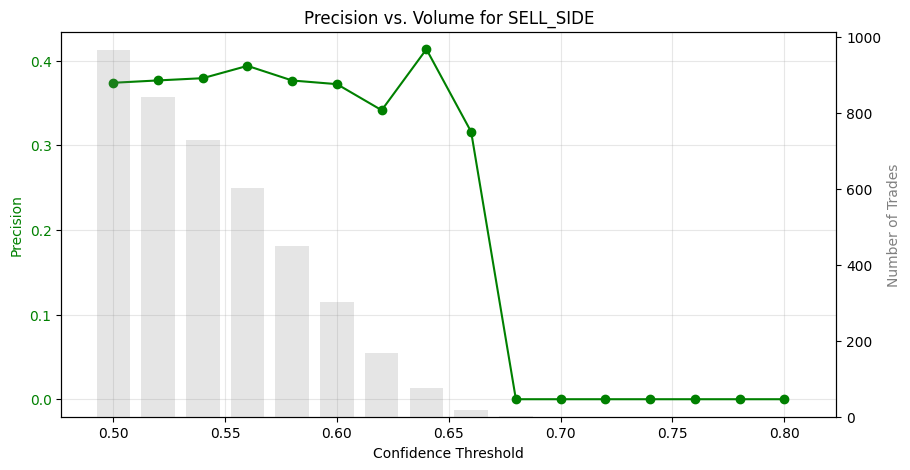

In [19]:
analyze_thresholds(model, X_test, y_test, model_type)


--- 1. Confusion Matrix (SELL_SIDE) ---
🎯 Precision (Win Rate): 37.37%
📡 Recall (Capture Rate):  62.03%


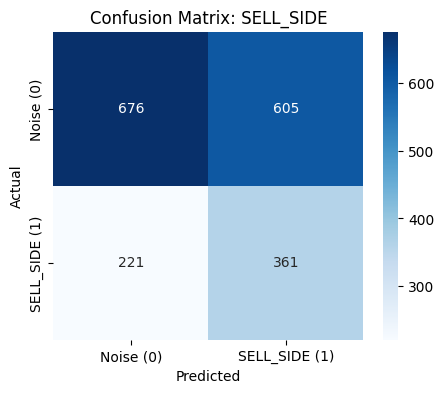


--- 2. How confident is the model? ---


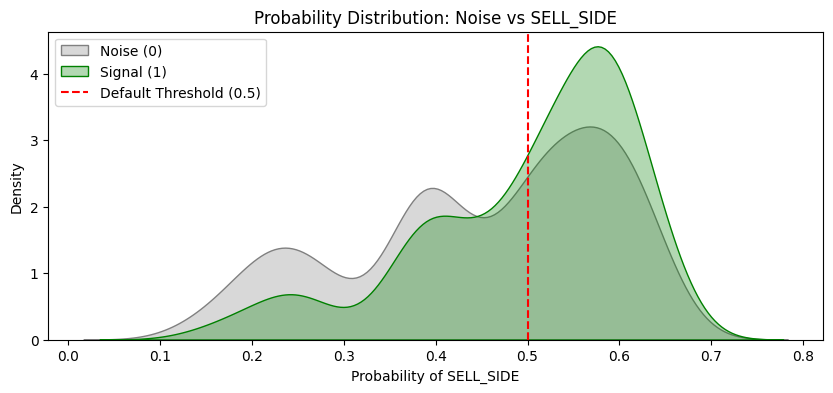


--- 3. Top Drivers ---


C:\Users\casus\AppData\Local\Temp\ipykernel_18160\3682795030.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feats[indices], palette='viridis')


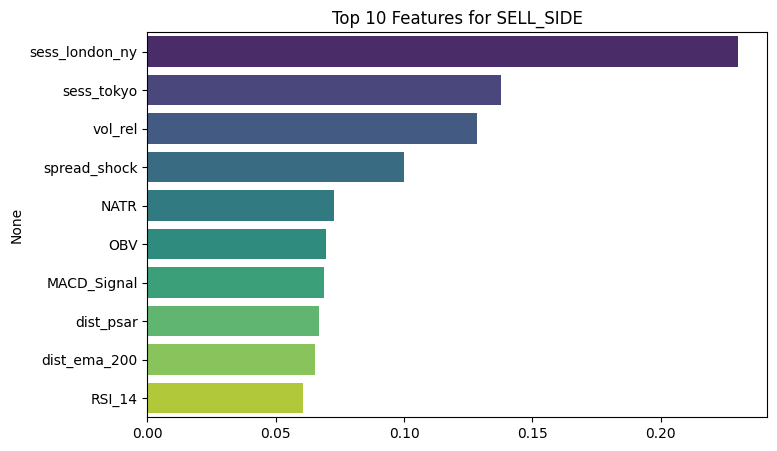

In [20]:
# Run Everything
run_diagnostics(model, X_test, y_test, model_type)